In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jax import vmap, jit
import jax.numpy as jnp
from pathlib import Path
import numpy as np
from einops import rearrange
import jax
import matplotlib.pyplot as plt
import seaborn as sns
from hflow.misc.plot import scatter_movie, imshow_movie

In [3]:
import jax.random
from diffrax import diffeqsolve, ControlTerm, Euler, MultiTerm, ODETerm, SaveAt, VirtualBrownianTree, Heun, WeaklyDiagonalControlTerm
import random



In [4]:
import jax.random
from diffrax import (ControlTerm, Euler, Heun, MultiTerm, ODETerm, SaveAt,
                     VirtualBrownianTree, diffeqsolve)
from jax import jit, vmap

import jax
import jax.numpy as jnp


def get_ic_osc(key):
    mu_0 = jnp.asarray([0, 10])
    ic = jax.random.normal(key, (2,))
    ic = (ic*0.5) - mu_0
    return ic


def get_2d_osc(mu):
    def drift(t, y, *args):
        xi, gamma, w = 0.20, mu, 1.0
        x1, x2 = y
        x1_dot = x2
        x2_dot = -2*xi*w*x2 + w**2*x1 - w**2*gamma*x1**3
        return jnp.asarray([x1_dot, x2_dot])

    def diffusion(t, y, *args):
        return jnp.asarray([0, 1])

    return drift, diffusion


# def get_ic_osc(key):
#     mu_0 = jnp.asarray([0, 0])
#     ic = jax.random.normal(key, (2,))
#     return ic

# def get_2d_osc(mu):
#     def drift(t, y, *args):
#         x1, x2 = y
#         x1_dot = x2
#         x2_dot = -x1
#         return jnp.asarray([x1_dot, x2_dot])*0.0

#     def diffusion(t, y, *args):
#         return jnp.asarray([1.0, 1.0])

#     return drift, diffusion

# import random



def solve_sde(drift, diffusion, t_eval, get_ic, n_samples, dt=1e-2, key=None):

    @jit
    def solve_single(key):
        t0, t1 = t_eval[0], t_eval[-1]
        ikey, skey = jax.random.split(key)
        y0 = get_ic(ikey)
        brownian_motion = VirtualBrownianTree(
            t0, t1, tol=1e-3, shape=y0.shape, key=skey)
        terms = MultiTerm(ODETerm(drift), WeaklyDiagonalControlTerm(
            diffusion, brownian_motion))
        solver = Euler()
        saveat = SaveAt(ts=t_eval)
        sol = diffeqsolve(terms, solver, t0, t1, dt0=dt,
                          y0=y0, saveat=saveat, max_steps=int(1e6))
        return sol.ys

    if key is None:
        key = jax.random.PRNGKey(random.randint(0, 1e6))
    keys = jax.random.split(key, num=n_samples)
    sols = vmap(solve_single)(keys)

    return sols


In [322]:
from scipy.special import roots_legendre, eval_legendre
def gauss_quadrature_weights_points(n, a=0, b=1):
    points, weights = roots_legendre(n)
    points = 0.5 * (points + 1) * (b - a) + a
    weights = weights * 0.5 * (b - a)
    return points, weights

bs_t = 128
t0, t1 = 0.0, 12
t_eval, t_weights = gauss_quadrature_weights_points(bs_t, a=t0, b=t1)
z, T = jnp.asarray([t0]), jnp.asarray([t1])
t_eval = jnp.concatenate([z, t_eval, T])

t_train = t_eval / t1
t_train = t_train.reshape(-1,1)
t_weights = t_weights / t1
# t_weights = t_weights * t1

In [323]:
n_samples = 20_000
# n_t = 1000
# t0, t1 = 0, 6
# t_eval = np.linspace(t0, t1, n_t)
mu = 0.05
drift, diffusion = get_2d_osc(mu)
sols = solve_sde(drift, diffusion, t_eval, get_ic_osc, n_samples)
sols = rearrange(sols, 'N T D -> T N D')

In [324]:
from hflow.data.utils import normalize
sols, d_shift, d_scale = normalize(
    sols, axis=(0, 1), return_stats=True, method='01')

In [325]:
scatter_movie(sols)

In [470]:
from hflow.net.build import build_colora
from typing import List, Optional

import jax.numpy as jnp
from jax.flatten_util import ravel_pytree

from hflow.net.networks import DNN
from hflow.net.utils import init_net, merge, split

key = jax.random.PRNGKey(random.randint(0,1e8))

x_dim = 2


u_layers = ['D']*7
h_layers = ['D']*4

u_hat_config = {'width': 55, 'layers': u_layers}
h_config = {'width': 25, 'layers': h_layers}

net_u = DNN(**u_hat_config, out_dim=1, period=None)
theta_init, u_fn = init_net(net_u, x_dim+1, key=key)

net_u = DNN(**h_config, out_dim=1, period=None)
psi_init, h_fn = init_net(net_u, x_dim+1, key=key)


params_init = (psi_init, theta_init)


def log_rho(x, t, psi):
    x_t = jnp.concatenate([x, t])
    p = h_fn(psi, x_t)
    return jnp.squeeze(p)

def s(t, x, params):
    psi, theta = params
    x_t = jnp.concatenate([x, t])
    rho = h_fn(psi, x_t)
    rho = jnp.exp(rho)

    rho_x = jnp.concatenate([rho, x])
    return jnp.squeeze(u_fn(theta, rho_x))


In [471]:
# net_u = DNN(width=64, layers=['D']*4, out_dim=u_dim, period=None)
# params_init, u_apply = init_net(net_u, x_dim+1, key=key)


# def s(t, x, params):
#     x_t = jnp.concatenate([x,t])
#     return jnp.squeeze(u_apply(params, x_t))


In [472]:

from jax import jit, jvp, grad, jacrev, jacfwd
from functools import partial


def trace_estimator(fn, argnum=0):
    
    d_fn = jacrev(fn, argnums=argnum)

    def est_trace(key, *args, **kwargs):
        args = list(args)
        primal = args[argnum]
        eps = jax.random.normal(key, shape=primal.shape)
        def s_dx_wrap(x):
            return d_fn(*args[:argnum], x, *args[argnum+1:], **kwargs)
        dx_val, jvp_val = jax.jvp(s_dx_wrap, (primal,), (eps,))
        trace = jnp.dot(eps, jvp_val)
        return dx_val, trace

    return est_trace


In [473]:
from jax import jit, jvp, grad, jacrev, jacfwd
from functools import partial

s_dt = jacrev(s, 0)
s_dt_Vx = vmap(s_dt, (None, 0, None))
s_dt_Vx_Vt = vmap(s_dt_Vx, (0, None, None))

s_Vx = vmap(s, in_axes=(None, 0, None))
s_Vx_Vt = vmap(s_Vx, in_axes=(0, None, None))
s_dx = jacrev(s, 1)
s_dx_Vx = vmap(s_dx, in_axes=(None, 0, None))
s_ddx_Vx = vmap(jacfwd(s_dx, 1), (None, 0, None))
s_dt_dx = jacrev(s, (0, 1))
s_dt_dx_Vx = vmap(s_dt_dx, in_axes=(None, 0, None))

trace_dds = trace_estimator(s, argnum=1)
trace_dds_Vx = vmap(trace_dds, (None, None, 0, None))


In [474]:


def score_match(x, t, psi):

    grad_log_p = jacfwd(log_rho)(x, t, psi)
    hess_log_p = jacrev(jacfwd(log_rho))(x, t, psi)

    l1 = jnp.sum(jnp.diag(hess_log_p))
    l2 = 0.5*jnp.linalg.norm(grad_log_p)**2
    return l1 + l2 


def score_match2(x, t, psi):


    hess_log_p = jacrev(grad_log_rho)(x, t, psi)

    l1 = jnp.sum(jnp.diag(hess_log_p))
    l2 = 0.5*jnp.linalg.norm(grad_log_rho(x, t, psi))**2
    return l1 + l2 


v_score_match = vmap(score_match2, (0, None, None))



In [475]:
from jax.experimental.host_callback import id_print, id_tap

import jax.flatten_util


noise = 0.0
sigma = 1e-1


res = []
def save_on_host(data, transforms):
    res.append(data)

def am_loss(psi_theta, x_t_batch, t_batch, key):

    # x_t_batch += jax.random.normal(key, shape=x_t_batch.shape)*sigma
    T, N, D = x_t_batch.shape
    T, MT = t_batch.shape
    bound = s_Vx(t_batch[0], x_t_batch[0], psi_theta) - \
        s_Vx(t_batch[-1], x_t_batch[-1], psi_theta)
        
    x_t_batch = x_t_batch[1:-1]
    t_batch = t_batch[1:-1]

    xt_tensor = rearrange(x_t_batch, 'T N D -> T (N D)')
    xt_tensor = jnp.hstack([xt_tensor, t_batch])

    def interior_loss(xt_tensor):
        x_batch, t = xt_tensor[:-MT], xt_tensor[-MT:]
        x_batch = rearrange(x_batch, '(N D) -> N D', D=D)

        # id_print(jnp.linalg.norm(x_batch))
        ut = s_dt_Vx(t, x_batch, psi_theta)
        ut = jnp.squeeze(ut)
        # # entropic
        if sigma > 0.0:

            gu, trace_ets = trace_dds_Vx(key, t, x_batch, psi_theta)
            ent = trace_ets*sigma**2*0.5
        else:
            gu = s_dx_Vx(t, x_batch, psi_theta)
            ent = 0.0
        gu = 0.5*jnp.sum(gu**2, axis=1)
    
        return gu.mean() + ut.mean() + ent.mean() 
    
    def vX_VT_score_match(xt_tensor):
        x_batch, t = xt_tensor[:-MT], xt_tensor[-MT:]
        x_batch = rearrange(x_batch, '(N D) -> N D', D=D)
        sm = v_score_match(x_batch, t, psi_theta[0])
        return sm.mean()
    
    
    interior = vmap(interior_loss)(xt_tensor)


    interior *= t_weights
    score = vmap(vX_VT_score_match)(xt_tensor)
    
    loss = (bound.mean() + interior.sum() + score.mean())


    return loss 


def get_rand_idx(key, N, bs):
    idx = jnp.arange(0, N)
    return jax.random.choice(key, idx, shape=(bs,), replace=False)


def get_data_fn(sols, t_data, bs_n, bs_t):
    T, N, D = sols.shape

    def args_fn(key):

        nonlocal sols
        nonlocal t_data

        key, keyt = jax.random.split(key)
 
        # t_idx = jax.random.choice(keyt, jnp.arange(1,T-1), shape=(bs_t-2,), replace=False)
        # start, end = jnp.asarray([0]), jnp.asarray([T-1])
        # t_idx = jnp.concatenate([start, t_idx, end])

        keys = jax.random.split(key, num=bs_t+2)
        keys *= 0 + key[0] 
        sample_idx = vmap(get_rand_idx, (0, None, None))(keys, N, bs_n)
        
        sols_sample = sols #[t_idx]
        t_sample = t_data #[t_idx]

        sols_sample = sols_sample[np.arange(len(sols_sample))[:, None], sample_idx]

        return sols_sample, t_sample
    return args_fn




In [476]:
bs_n = 128
key = jax.random.PRNGKey(np.random.randint(0,1e5))
args_fn = get_data_fn(sols, t_train, bs_n, bs_t)
x_t_batch, t_batch = args_fn(key)
x_t_batch.shape, t_batch.shape

((130, 128, 2), (130, 1))

In [477]:
from hflow.train.adam import adam_opt

last_params, opt_params, loss_history, param_history = adam_opt(params_init, am_loss, args_fn, steps=5_000, learning_rate=1e-2, verbose=True, scheduler=True, key=key, return_params=True)



  0%|          | 0/5000 [00:00<?, ?it/s]

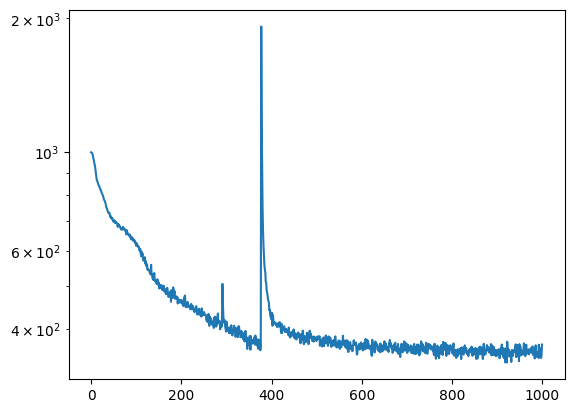

In [478]:
plt.semilogy(loss_history+1000)
plt.show()

In [479]:
# res = np.asarray(res)
# plt.semilogy(res)
# plt.legend(['gu','ut', 'gu weight', 'ut weight'])
# plt.show()

# plt.plot(res)
# plt.legend(['gu','ut', 'gu weight', 'ut weight'])
# plt.show()

In [480]:
nx = 50
xA, xB = sols[:, :, 0].min(), sols[:, :, 0].max()
yA, yB = sols[:, :, 1].min(), sols[:, :, 1].max()
x1, x2 = jnp.linspace(xA, xB, nx), jnp.linspace(yA, yB, nx)
m_grids = jnp.meshgrid(x1, x2,  indexing='ij')
x_grid = jnp.asarray([m.flatten() for m in m_grids]).T

t_test = t_train

pred = s_Vx_Vt(t_test, x_grid, opt_params)
pred = rearrange(pred, 'T (N1 N2)-> (T) N1 N2', T=len(t_test), N1=nx, N2=nx)

imshow_movie(pred, live_cbar=True)


In [489]:
from hflow.data.ode import odeint_rk4

t_int = np.linspace(0, 1, 100)
dt = t_int[1]
y0 = sols[0]
def fn(t, y):
    f = jnp.squeeze(s_dx_Vx(t.reshape(1), y, opt_params))
    return f
    
    
int_sol = odeint_rk4(fn, y0, t_int)
     

In [490]:
def get_ic_scaled(key):
    ic = get_ic_osc(key)
    ic = (ic - np.squeeze(d_shift)) / np.squeeze(d_scale)
    return ic

def drift(t, y, *args):
    f = jnp.squeeze(s_dx(t.reshape(1), y, opt_params))
    return f

def diffusion(t, y, *args):
    return sigma * jnp.ones_like(y)

int_sol = solve_sde(drift, diffusion, t_int, get_ic_scaled, n_samples, dt=1e-3)
int_sol = rearrange(int_sol, 'N T D -> T N D')

In [491]:
ss = 10
scatter_movie(int_sol[:, ::ss], t=t_int, xlim=[0,1], ylim=[0,1])

In [492]:
# ss = 20
# all_sol = jnp.hstack([sols, int_sol])
# L = int_sol[ :, ::ss].shape[1]
# cs = [*['r']*L,*['b']*L]
# scatter_movie(all_sol[:, ::ss], t=t_int, c=cs, alpha=0.3,xlim=[0,1], ylim=[0,1],)#,  save_to='/p/home/jmb/sc/rommc/roll_am', fps=5)

In [493]:
from hflow.misc.misc import pts_array_from_space    
    
h_Vx = vmap(h_fn, (None, 0))
nx = 50
x1, t1 = jnp.linspace(0.0, 1.0, nx), jnp.linspace(0.0, 1.0, nx)
x_t = pts_array_from_space([x1, x1, t1])
psi = opt_params[0]
phi = h_Vx(psi, x_t)


In [494]:
phi_xt = rearrange(phi, '(x y t) d -> d t x y', x=nx, y=nx, t=nx)

In [487]:
imshow_movie(phi_xt[0], live_cbar=True)

In [488]:
imshow_movie(np.exp(phi_xt[0]), live_cbar=True)

/state/partition1/job-45281399/ipykernel_1153166/2629797965.py:1: RuntimeWarning: overflow encountered in exp
  imshow_movie(np.exp(phi_xt[0]), live_cbar=True)
